
# 📘 Experiment Log : Assignment 1 - svm.ipynb

- 과제 완료일: 2025.01.10 ~ 2025.03.19 (약 두 달의 공백기가 있었음.)
- 이 마크다운은 2025.03.29 에 복습과 문서화를 위해 작성됨.

---

## 1. 과제 개요
- CIFAR-10 데이터셋을 바탕으로 numpy만으로 SVM classfier 구현해보기
- 목표: 두 가지 방법(반복문 사용, vectorized)으로 SVM의 loss와 gradient를 계산하는 코드 작성. 이후 CIFAR-10 데이터셋으로 학습 후 결과 도출.
- loss와 gradient를 계산하는 코드는 linear_svm.py 파일에 있음.

---

## 2. 당시 구현 내용 요약
- `svm_loss_naive()` / `svm_loss_vectorized()` 함수 구현
- 행렬의 곱이 완전히 익숙하진 않아서 처음에 vectorized 방법을 구현하기가 쉽지 않았음.
- 그러나 오랜 고민 끝에 결국 성공했고, 이후에 softmax의 vectorized 방법을 구현할 때는 훨씬 빨리 했던 기억이 있음. -> 하다 보면 더 늘지 않을까? 그리고 헷갈리면 계산 그래프를 그려보는 게 가장 쉽고 확실할 것 같음.
- 하이퍼파라미터:
  - learning rate: [1e-8, 5e-8, 1e-7, 5e-7, 1e-6]
  - regularization strengths: [5e3, 7.5e3, 1e4, 2.5e4, 5e4]
- best :
    - lr : 5e-7 / reg : 5e3 / train accuracy: 0.374408 / val accuracy: 0.382000 / test set accuracy: 0.366000

---

## 3. 다시 보며 복습한 내용
- svm에서의 loss 와 gradient 계산 방법
- deepcopy를 사용 해야 하는지에 대한 고민 : best_val 구하는 셀에 자세히 기록
- 하이퍼파라미터 grid search를 할 때 이전 모델이 재활용되는 것을 방지하기 위해 deepcopy를 사용할 수 있음. 하지만 이번 과제에서의 코드처럼 작성하면 재활용 자체를 방지할 수 있음.


---

## 4. 개선 아이디어
- 성능을 더 높이고 싶다면 grid search를 더 촘촘하게 진행할 수도 있을 것 같다.

---


In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'Colab_Notebooks/cs231n/cs231n_assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab_Notebooks/cs231n/cs231n_assignment1/cs231n/datasets
/content/drive/My Drive/Colab_Notebooks/cs231n/cs231n_assignment1


# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [3]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [4]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


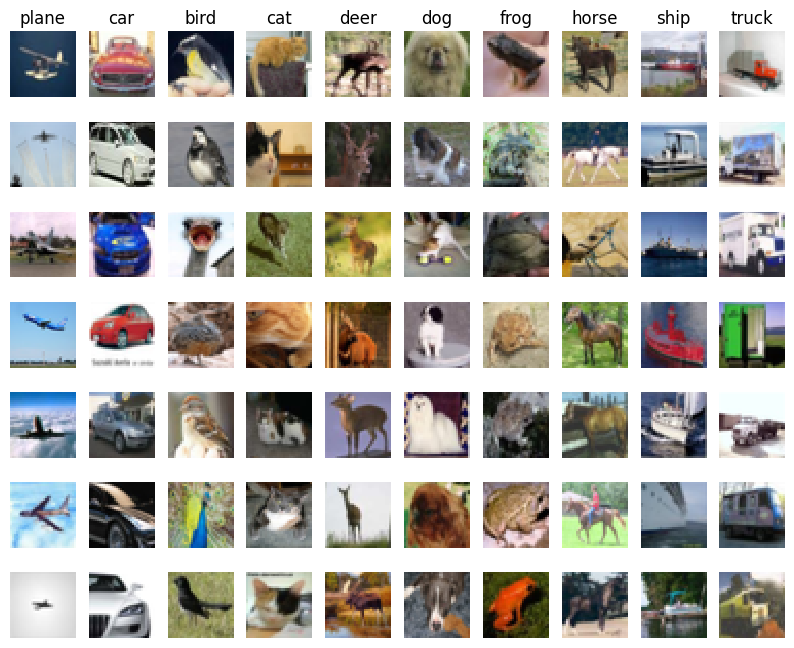

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [7]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


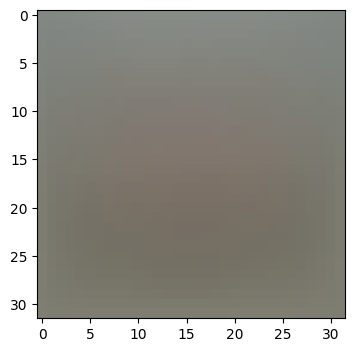

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [8]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`.

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function.

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.160642


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 20.297790 analytic: 20.297790, relative error: 6.714485e-12
numerical: -3.495223 analytic: -3.495223, relative error: 2.888746e-12
numerical: 8.833473 analytic: 8.833473, relative error: 6.930277e-11
numerical: 0.185165 analytic: 0.185165, relative error: 1.109888e-09
numerical: 10.593868 analytic: 10.593868, relative error: 2.630597e-11
numerical: 6.461634 analytic: 6.461634, relative error: 1.137172e-11
numerical: 21.443410 analytic: 21.443410, relative error: 4.682242e-12
numerical: 9.638569 analytic: 9.638569, relative error: 5.536458e-12
numerical: 8.632324 analytic: 8.632324, relative error: 9.519471e-12
numerical: 8.976700 analytic: 9.007438, relative error: 1.709193e-03
numerical: 1.666428 analytic: 1.692397, relative error: 7.731466e-03
numerical: 13.305275 analytic: 13.305275, relative error: 2.621691e-11
numerical: 5.843974 analytic: 5.843974, relative error: 2.463665e-11
numerical: -23.620972 analytic: -23.620972, relative error: 8.908717e-12
numerical: 0.332884 

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *Because SVM loss function is not differentiable near zero. The change of margin doesn't affect because the number of non-differentiable points is not changed.



In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

## // 2025.01.10 완료

Naive loss: 9.160642e+00 computed in 0.121243s
Vectorized loss: 9.160642e+00 computed in 0.011307s
difference: 0.000000


In [12]:
import numpy as np
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)


Naive loss and gradient: computed in 0.243333s
Vectorized loss and gradient: computed in 0.011480s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 797.520002
iteration 100 / 1500: loss 290.735756
iteration 200 / 1500: loss 109.196334
iteration 300 / 1500: loss 42.844453
iteration 400 / 1500: loss 18.963867
iteration 500 / 1500: loss 10.394005
iteration 600 / 1500: loss 7.297338
iteration 700 / 1500: loss 5.577594
iteration 800 / 1500: loss 5.639635
iteration 900 / 1500: loss 5.332403
iteration 1000 / 1500: loss 5.746680
iteration 1100 / 1500: loss 5.486982
iteration 1200 / 1500: loss 5.081144
iteration 1300 / 1500: loss 5.147066
iteration 1400 / 1500: loss 5.295589
That took 9.432735s


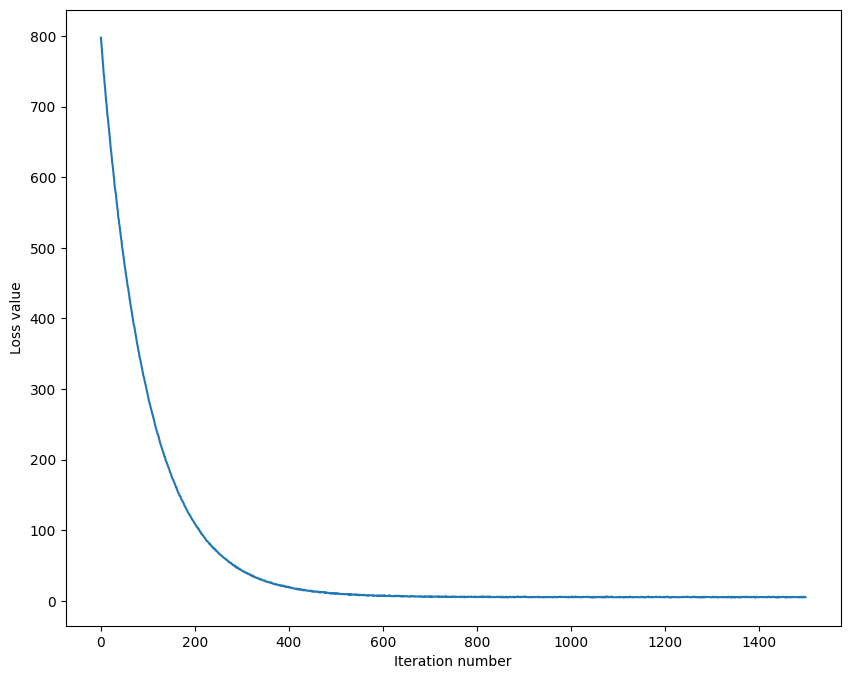

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.368367
validation accuracy: 0.375000


In [16]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 (> 0.385) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search.
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.

# import copy
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters

learning_rates = [1e-8, 5e-8, 1e-7, 5e-7, 1e-6]
regularization_strengths = [5e3, 7.5e3, 1e4, 2.5e4, 5e4]


# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

iter = 0

for lr in learning_rates:
    for reg in regularization_strengths:
        val_svm = LinearSVM()
        val_svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=800, verbose=False)
        y_train_pred = val_svm.predict(X_train)
        y_val_pred = val_svm.predict(X_val)
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if (val_accuracy > best_val):
            best_val = val_accuracy
            best_svm = val_svm  # [2025.03.29] 의문점 : deepcopy를 사용하지 않아도 되는가? -> 실험 결과 아래에
        iter += 1
        print(f"{iter}/{len(learning_rates) * len(regularization_strengths)}")


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
results = dict(sorted(results.items(), key=lambda x: x[1][1], reverse=True))
for lr, reg in results:
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)
print("Validation Accuracy of best_svm:", np.mean(best_svm.predict(X_val) == y_val)) ## deepcopy를 사용하지 않았을 때 참조가 제대로 일어났는지 확인용


# [2025.03.29]
# deepcopy 사용 시:
# best validation accuracy achieved during cross-validation: 0.382000
# Validation Accuracy of best_svm: 0.382

# deepcopy 미사용 시
# best validation accuracy achieved during cross-validation: 0.384000
# Validation Accuracy of best_svm: 0.384

# deepcopy를 사용하지 않아도 문제 없는 것이 확인 됨.

# why?
# -> val_svm = LinearSVM() 반복문 안쪽에서 이와 같이 새롭게 SVM이 생성되기 때문.
# 나는 저렇게 적으면 혹시나 이전 반복의 svm을 재활용하게 되는 건 아닌지 걱정했는데 LinearSVM()을 호출할 때마다 새롭게 생성되는 것 같다.

# 그렇다면 앞으로 deepcopy를 사용 안 해도 되나?
# -> 쓰는 게 안전하긴 한데 gpt한테 물어보니까 deepcopy는 객체를 재귀적으로 완전히 복사하는 것이라고 함. 따라서 CNN 등으로 모델이 복잡해 질수록 시간이 오래 걸릴 듯 함.
#    이제 이전 모델이 재활용되는지의 여부를 판단할 수 있게 됐으므로 확실한 상황에서는 deepcopy를 사용하지 않아도 될 듯 함.
#    다만 재활용 여부가 확실하지 않을 때는 너무 복잡한 모델이 아닌 이상 deepcopy를 사용하면 안전할 것 같음.

# softmax.ipynb 에도 deepcopy를 사용했었는데 아마 그거도 필요없을듯함.


1/25
2/25
3/25
4/25
5/25
6/25
7/25
8/25
9/25
10/25
11/25
12/25
13/25
14/25
15/25
16/25
17/25
18/25
19/25
20/25
21/25
22/25
23/25
24/25
25/25
lr 5.000000e-07 reg 5.000000e+03 train accuracy: 0.374408 val accuracy: 0.382000
lr 5.000000e-08 reg 5.000000e+04 train accuracy: 0.364327 val accuracy: 0.378000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.364306 val accuracy: 0.372000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.364980 val accuracy: 0.367000
lr 5.000000e-07 reg 1.000000e+04 train accuracy: 0.350714 val accuracy: 0.365000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.349449 val accuracy: 0.363000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.357878 val accuracy: 0.359000
lr 5.000000e-07 reg 7.500000e+03 train accuracy: 0.331755 val accuracy: 0.359000
lr 5.000000e-08 reg 2.500000e+04 train accuracy: 0.350612 val accuracy: 0.357000
lr 1.000000e-06 reg 5.000000e+03 train accuracy: 0.344163 val accuracy: 0.347000
lr 1.000000e-07 reg 7.500000e+03 train accuracy: 

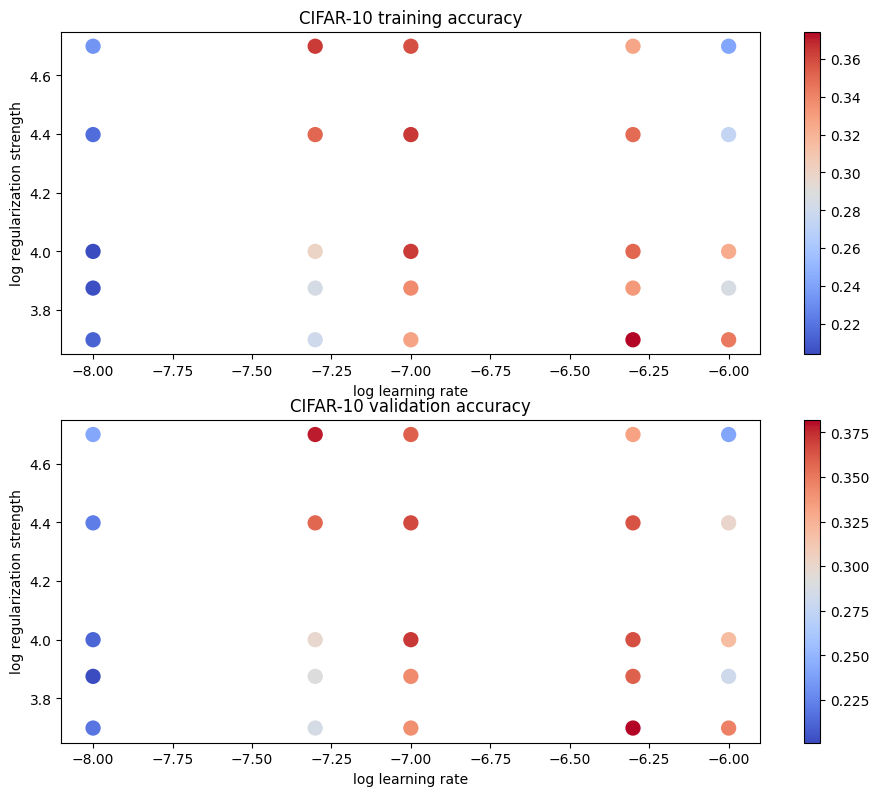

In [17]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [18]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.366000


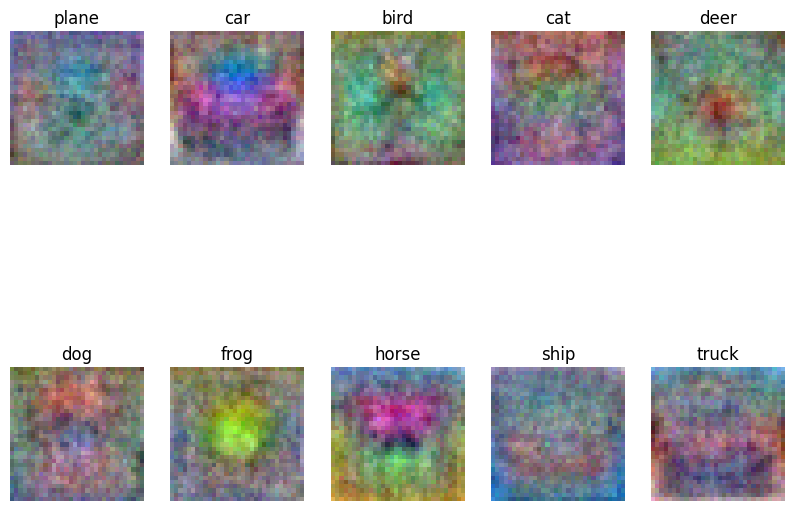

In [19]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$ 그 객체의 실루엣이 희미하게 보인다. X(N,D) 와 W(D,C)를 곱하게 될 때 X의 행과 W의 열끼리 내적을 하게 되는데, 내적은 두 벡터의 유사성이 높을수록 값이 커지게 된다. 즉, W를 최적화하게 되면 W는 점점 X가 나타내는 정답 이미지의 대략적인 실루엣과 비슷한 모양으로 나타날 것이다.
